In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pred_vs_actual(index, y_true, y_pred, model_name, start=None, end=None, save_path=None):
    """
    index     : pandas.DatetimeIndex (or array-like) aligned with y_true/y_pred
    y_true    : 1D array-like of actual values
    y_pred    : 1D array-like of predictions (aligned to y_true)
    model_name: label for the title/legend
    start,end : optional slice to zoom (e.g., '2016-05-10', '2016-05-15' or integer slice)
    save_path : optional path to save the PNG
    """
    
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    dfp = pd.DataFrame({"y_true": y_true, "y_pred": y_pred}, index=index)
    if start is not None or end is not None:
        dfp = dfp.loc[start:end]

    plt.figure(figsize=(12,5))
    plt.plot(dfp.index, dfp["y_true"], label="Actual", alpha=0.9)
    plt.plot(dfp.index, dfp["y_pred"], label=model_name, alpha=0.85)
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Energy (Appliances)")
    plt.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=120, bbox_inches="tight")
    plt.show()

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100)

def log_model_result(model_name, y_true, y_pred, n_params=None, extra=None,
                     csv_path="reports/model_scores.csv"):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae  = float(mean_absolute_error(y_true, y_pred))
    rmse = float(mean_squared_error(y_true, y_pred) ** 0.5)
    mp   = mape(y_true, y_pred)

    row = {"model": model_name, "MAE": mae, "RMSE": rmse, "MAPE": mp,
           "n_params": (int(n_params) if n_params is not None else np.nan)}
    if isinstance(extra, dict):
        row.update(extra)

    p = Path(csv_path)
    p.parent.mkdir(parents=True, exist_ok=True)
    header = not p.exists()
    pd.DataFrame([row]).to_csv(p, mode="a", header=header, index=False)

In [5]:
import pandas as pd, numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"])
y = (df.sort_values("date").set_index("date")["Appliances"]
       .resample("H").mean().asfreq("H").interpolate())
print("len(y) hourly:", len(y))

len(y) hourly: 3290


C:\Users\mirun\AppData\Local\Temp\ipykernel_7768\3773027858.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H").mean().asfreq("H").interpolate())


In [2]:
ys = y.iloc[:500]
split = int(len(ys)*0.8)
y_tr, y_te = ys.iloc[:split], ys.iloc[split:]

t0 = time.time()
m = SARIMAX(y_tr, order=(1,0,0), seasonal_order=(0,0,0,24))
r = m.fit(disp=False, maxiter=10)
pred = r.get_forecast(steps=len(y_te)).predicted_mean
mae = mean_absolute_error(y_te, pred)
rmse = np.sqrt(mean_squared_error(y_te, pred))
print({"SMOKE_MAE": mae, "SMOKE_RMSE": rmse, "secs": round(time.time()-t0,2)})

{'SMOKE_MAE': 92.40857697952241, 'SMOKE_RMSE': np.float64(136.50710902070378), 'secs': 0.05}


{'ARIMA_MAE': 36.551888464767735, 'ARIMA_RMSE': np.float64(60.25206031878127), 'secs': 71.58}


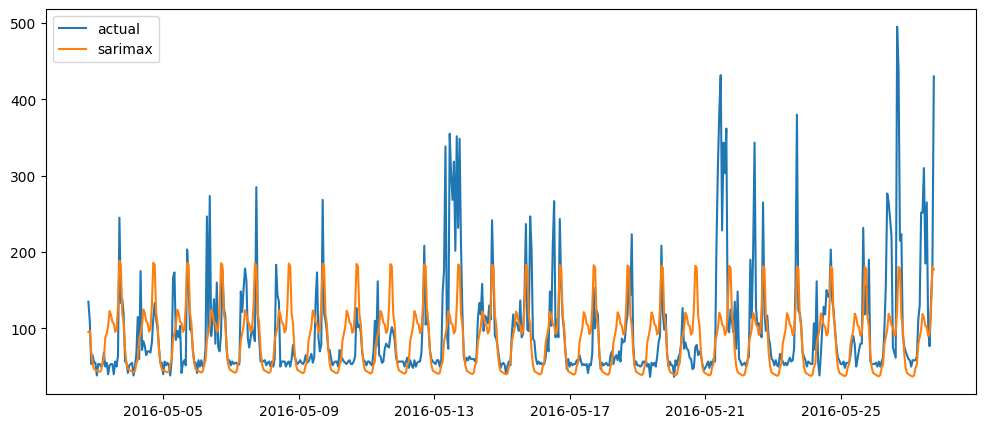

In [3]:
ys = y.tail(3000)
split = int(len(ys)*0.8)
y_tr, y_te = ys.iloc[:split], ys.iloc[split:]

t0 = time.time()
m = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,24),
            enforce_stationarity=False, enforce_invertibility=False)
r = m.fit(disp=False, maxiter=60)
pred = r.get_forecast(steps=len(y_te)).predicted_mean
mae = mean_absolute_error(y_te, pred)
rmse = np.sqrt(mean_squared_error(y_te, pred))
print({"ARIMA_MAE": mae, "ARIMA_RMSE": rmse, "secs": round(time.time()-t0,2)})

plt.figure(figsize=(12,5))
plt.plot(y_te.index, y_te.values, label="actual")
plt.plot(y_te.index, pred.values, label="sarimax")
plt.legend(); plt.show()


C:\Users\mirun\AppData\Local\Temp\ipykernel_13896\2260686808.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("H").mean().asfreq("H").interpolate())


{'ARIMA_MAE': 36.551888464767735, 'ARIMA_RMSE': np.float64(60.25206031878127)}


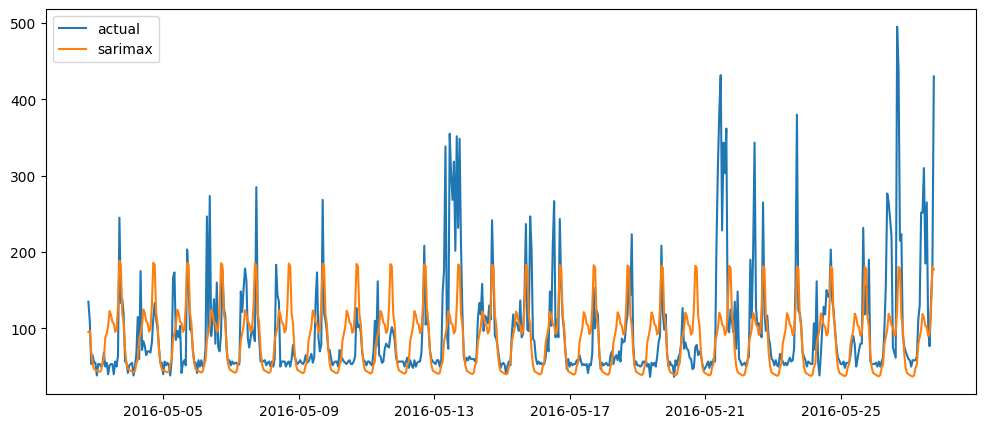

<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"])
y = (df.sort_values("date").set_index("date")["Appliances"]
       .resample("H").mean().asfreq("H").interpolate())

ys = y.tail(3000)
split = int(len(ys)*0.8)
y_tr, y_te = ys.iloc[:split], ys.iloc[split:]

order = (1,1,1)
seasonal = (1,1,1,24)

m = SARIMAX(y_tr, order=order, seasonal_order=seasonal,
            enforce_stationarity=False, enforce_invertibility=False)
r = m.fit(disp=False, maxiter=60)

pred = r.get_forecast(steps=len(y_te)).predicted_mean
mae = mean_absolute_error(y_te, pred)
rmse = np.sqrt(mean_squared_error(y_te, pred))
print({"ARIMA_MAE": mae, "ARIMA_RMSE": rmse})

plt.figure(figsize=(12,5))
plt.plot(y_te.index, y_te.values, label="actual")
plt.plot(y_te.index, pred.values, label="sarimax")
plt.legend()
plt.show()

pd.DataFrame({"metric":["MAE","RMSE"],"value":[mae,rmse]}).to_csv(
    "reports/figures/arima_hourly_metrics.csv", index=False
)
plt.savefig("reports/figures/arima_hourly_plot.png", bbox_inches="tight")

with open("models/arima_hourly.pkl", "wb") as f:
    pickle.dump(r, f)

C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'SARIMAX_exog_MAE': 39.792060952202625, 'SARIMAX_exog_RMSE': np.float64(61.97931177034387)}


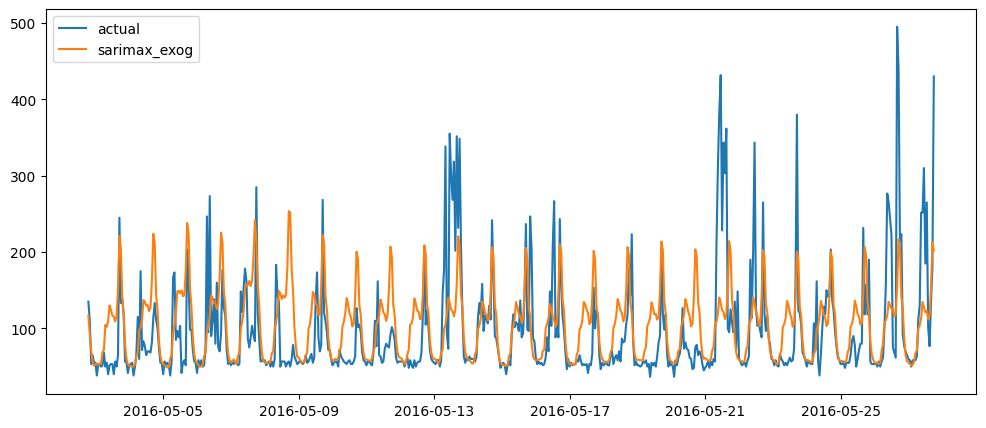

<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"]).sort_values("date")
df = df.set_index("date")

y = df["Appliances"].resample("h").mean().asfreq("h").interpolate()
X = df[["T_out","RH_out","Windspeed","Visibility","Tdewpoint"]].resample("h").mean().asfreq("h").interpolate()

ys = y.tail(3000)
Xs = X.tail(3000)

split = int(len(ys)*0.8)
y_tr, y_te = ys.iloc[:split], ys.iloc[split:]
X_tr, X_te = Xs.iloc[:split], Xs.iloc[split:]

order = (2,1,1)
seasonal = (1,1,1,24)

m = SARIMAX(y_tr, exog=X_tr, order=order, seasonal_order=seasonal,
            enforce_stationarity=False, enforce_invertibility=False)
r = m.fit(disp=False, maxiter=60)

pred = r.get_forecast(steps=len(y_te), exog=X_te).predicted_mean
mae = mean_absolute_error(y_te, pred)
rmse = np.sqrt(mean_squared_error(y_te, pred))
print({"SARIMAX_exog_MAE": mae, "SARIMAX_exog_RMSE": rmse})

plt.figure(figsize=(12,5))
plt.plot(y_te.index, y_te.values, label="actual")
plt.plot(y_te.index, pred.values, label="sarimax_exog")
plt.legend(); plt.show()

pd.DataFrame({"metric":["MAE","RMSE"],"value":[mae,rmse]}).to_csv(
    "reports/figures/sarimax_exog_hourly_metrics.csv", index=False
)
plt.savefig("reports/figures/sarimax_exog_hourly_plot.png", bbox_inches="tight")

with open("models/sarimax_exog_hourly.pkl","wb") as f:
    pickle.dump(r, f)


C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'SARIMAX_exog_log_MAE': 34.936700797188536, 'SARIMAX_exog_log_RMSE': np.float64(62.39361690619407)}


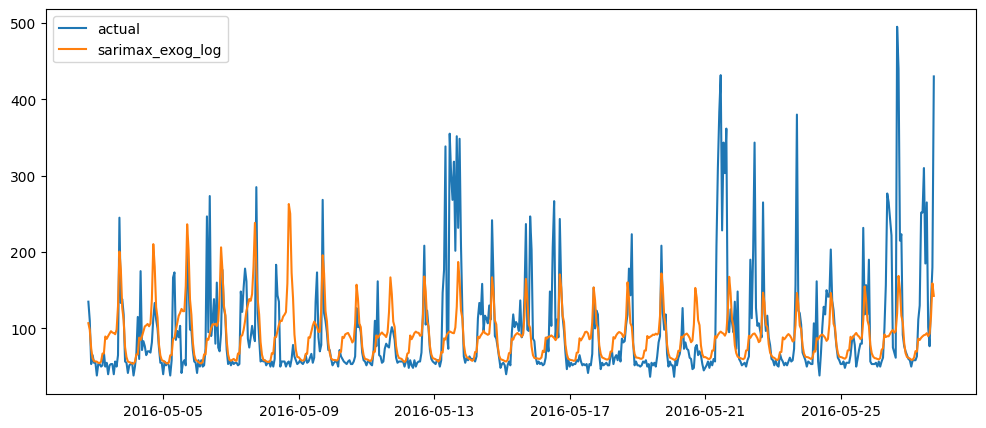

<Figure size 640x480 with 0 Axes>

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"]).sort_values("date").set_index("date")

y_raw = df["Appliances"].resample("h").mean().asfreq("h").interpolate()
X_raw = df[["T_out","RH_out","Windspeed","Visibility","Tdewpoint"]].resample("h").mean().asfreq("h").interpolate()

X = (X_raw - X_raw.mean()) / X_raw.std()
y = np.log1p(y_raw)

ys = y.tail(3000)
Xs = X.tail(3000)

split = int(len(ys)*0.8)
y_tr, y_te = ys.iloc[:split], ys.iloc[split:]
X_tr, X_te = Xs.iloc[:split], Xs.iloc[split:]

order = (2,0,2)
seasonal = (1,0,1,24)

m = SARIMAX(y_tr, exog=X_tr, order=order, seasonal_order=seasonal,
            trend="c", enforce_stationarity=False, enforce_invertibility=False)
r = m.fit(disp=False, maxiter=200, method="lbfgs")

pred_log = r.get_forecast(steps=len(y_te), exog=X_te).predicted_mean
pred = np.expm1(pred_log)
y_true = np.expm1(y_te)

mae = mean_absolute_error(y_true, pred)
rmse = np.sqrt(mean_squared_error(y_true, pred))
print({"SARIMAX_exog_log_MAE": mae, "SARIMAX_exog_log_RMSE": rmse})

plt.figure(figsize=(12,5))
plt.plot(y_true.index, y_true.values, label="actual")
plt.plot(y_true.index, pred.values, label="sarimax_exog_log")
plt.legend(); plt.show()

pd.DataFrame({"metric":["MAE","RMSE"],"value":[mae,rmse]}).to_csv(
    "reports/figures/sarimax_exog_log_hourly_metrics.csv", index=False
)
plt.savefig("reports/figures/sarimax_exog_log_hourly_plot.png", bbox_inches="tight")

with open("models/sarimax_exog_log_hourly.pkl","wb") as f:
    pickle.dump(r, f)

In [5]:
log_model_result(
    model_name="SARIMAX_exog_log (2,0,2)x(1,0,1,24)",
    y_true=y_true.values,
    y_pred=np.asarray(pred).ravel(),
    n_params=len(r.params),
)

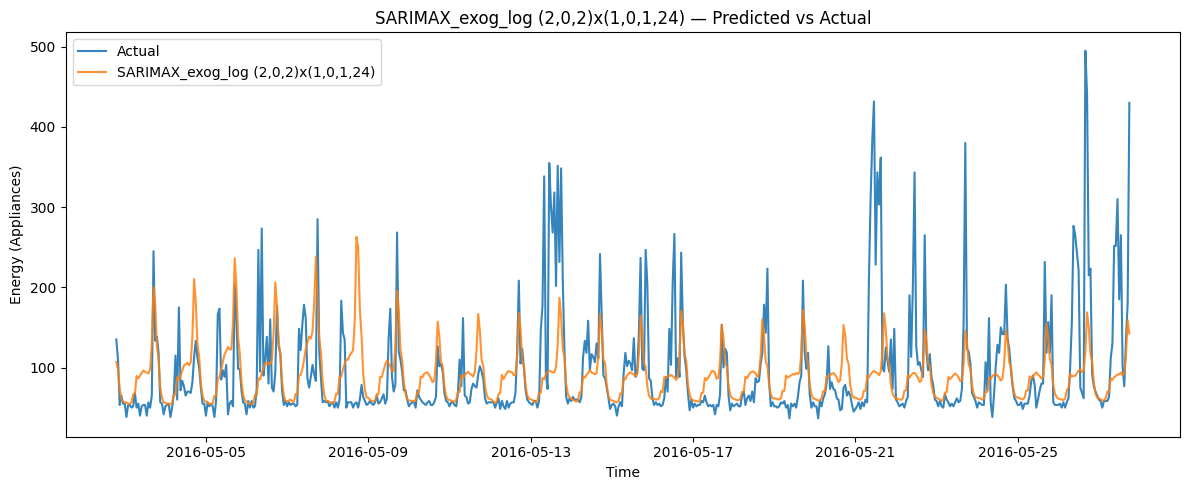

In [7]:
plot_pred_vs_actual(
    index=y_true.index,
    y_true=y_true.values,
    y_pred=np.asarray(pred).ravel(),
    model_name="SARIMAX_exog_log (2,0,2)x(1,0,1,24)",
    save_path="reports/figures/sarimax_pred_vs_actual.png"
)

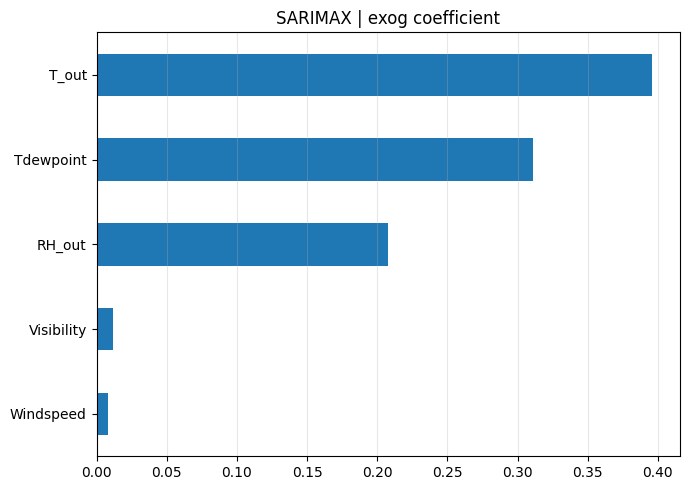

In [8]:

import re
import pandas as pd
import matplotlib.pyplot as plt

names = r.params.index.astype(str)

coef_map = {}
for c in X_tr.columns:
    pname = next((n for n in names if re.search(fr"\b{re.escape(c)}\b", n)), None)
    if pname is not None:
        coef_map[c] = r.params[pname]

if not coef_map:
    print("Could not match exogenous coefficients by name – inspect r.params to see how they're labeled:")
    display(r.params)
else:
    s = pd.Series(coef_map).sort_values(key=lambda v: v.abs())
    ax = s.abs().plot(kind="barh", figsize=(7, 5), title="SARIMAX | exog coefficient")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()
